<a href="https://colab.research.google.com/github/AnHaiTrinh/handson-ml/blob/main/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, load_iris, fetch_openml
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingRegressor, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
proba = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

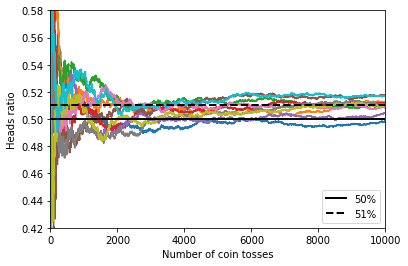

In [3]:
plt.plot(proba)
plt.plot([0, 10000], [0.5, 0.5], 'k-', label='50%', linewidth=2)
plt.plot([0, 10000], [0.51, 0.51], 'k--', label='51%', linewidth=2)
plt.xlabel('Number of coin tosses')
plt.ylabel('Heads ratio')
plt.axis([0, 10000, 0.42, 0.58])
plt.legend(loc='lower right')

In [4]:
X, y = make_moons(n_samples=1000, noise=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [5]:
forest_clf = RandomForestClassifier(n_estimators=100)
log_clf = LogisticRegression(solver='lbfgs')
svm_clf = SVC(gamma='scale', probability=True)

In [6]:
voting_clf = VotingClassifier(estimators=[('rf', forest_clf), ('lr', log_clf), ('svm', svm_clf)], voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('lr', LogisticRegression()),
                             ('svm', SVC(probability=True))],
                 voting='soft')

In [7]:
bagging_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                                max_samples=100, bootstrap=True, oob_score=True, n_jobs=-1)
bagging_clf.fit(X_train, y_train)
y_pred = bagging_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.925

In [8]:
bagging_clf = BaggingClassifier(DecisionTreeClassifier(splitter='random', max_leaf_nodes=16),
                                n_estimators=500, max_samples=1.0, oob_score=True, bootstrap=True, n_jobs=-1)
bagging_clf.fit(X_train, y_train)
y_pred = bagging_clf.predict(X_test)
print(bagging_clf.oob_score_)
accuracy_score(y_test, y_pred)

0.9125


0.925

In [9]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

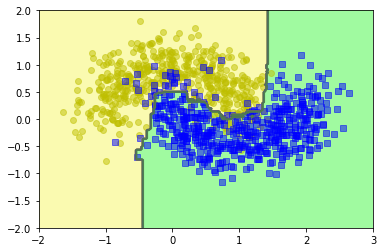

In [10]:
plt.plot(X[y == 0, 0], X[y == 0, 1], 'yo', label='0', alpha=0.5)
plt.plot(X[y == 1, 0], X[y == 1, 1], 'bs', label='1', alpha=0.5)
x0, x1 = np.meshgrid(np.linspace(-2, 3, 250),
                     np.linspace(-2, 2, 200))
X_new = np.c_[x0.ravel(), x1.ravel()]
y_pred = rnd_clf.predict(X_new).reshape(x0.shape)
plt.contourf(x0, x1, y_pred, cmap=ListedColormap(['#fafab0', '#9898ff', '#a0faa0']))
plt.contour(x0, x1, y_pred, cmap = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50']), alpha=0.9)

In [11]:
y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.91

In [12]:
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11011882629554146
sepal width (cm) 0.027397526133815443
petal length (cm) 0.43427956347072516
petal width (cm) 0.428204084099918


In [13]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(mnist.data, mnist.target)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [14]:
feat_importance = rnd_clf.feature_importances_

[Text(1, 0.0, 'Not important'), Text(1, 0.00907151331703535, 'Very important')]

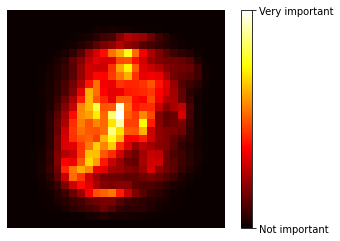

In [15]:
image = feat_importance.reshape(28, 28)
plt.imshow(image, cmap=mpl.cm.hot, interpolation='nearest')
plt.axis('off')
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

In [16]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,
                             algorithm='SAMME.R', learning_rate=0.5)
ada_clf.fit(mnist.data[:60000], mnist.target[:60000])
y_pred = ada_clf.predict(mnist.data[60000:])
accuracy_score(mnist.target[60000:], y_pred)

0.7785

In [17]:
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [18]:
def plot_prediction(models, range, style, label):
    X_new = np.linspace(range[0], range[1], 200).reshape(-1, 1)
    y_pred = sum(model.predict(X_new) for model in models)
    plt.plot(X_new, y_pred, style, label=label)
    plt.legend(loc='upper center', fontsize=8)

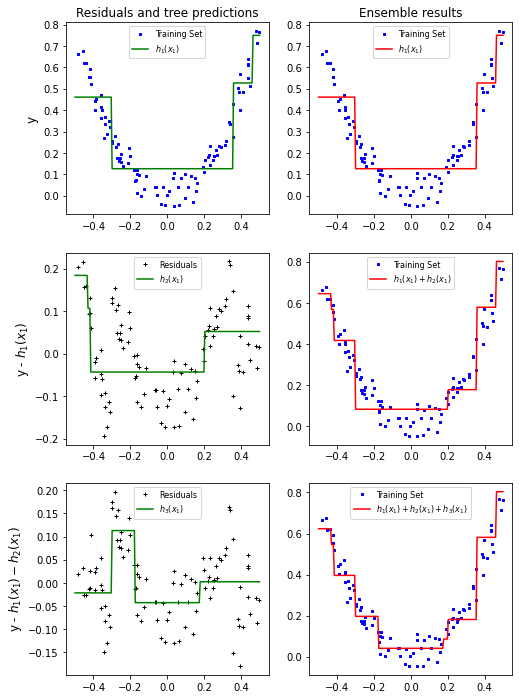

In [19]:
plt.figure(figsize=(8, 12))
plt.subplot(321)
plt.plot(X, y, 'bs', label='Training Set', markersize=2)
plot_prediction([tree_reg1], [-0.5, 0.5], 'g-', '$h_1(x_1)$')
plt.ylabel('y', fontsize=12)
plt.title('Residuals and tree predictions')
plt.subplot(322)
plt.plot(X, y, 'bs', label='Training Set', markersize=2)
plot_prediction([tree_reg1], [-0.5, 0.5], 'r-', '$h_1(x_1)$')
plt.title('Ensemble results')
plt.subplot(323)
plt.plot(X, y2, 'k+', label='Residuals', markersize=4)
plot_prediction([tree_reg2], [-0.5, 0.5], 'g-', '$h_2(x_1)$')
plt.ylabel('y - $h_1(x_1)$', fontsize=12)
plt.subplot(324)
plt.plot(X, y, 'bs', label='Training Set', markersize=2)
plot_prediction([tree_reg1, tree_reg2], [-0.5, 0.5], 'r-', '$h_1(x_1) + h_2(x_1)$')
plt.subplot(325)
plt.plot(X, y3, 'k+', label='Residuals', markersize=4)
plot_prediction([tree_reg3], [-0.5, 0.5], 'g-', '$h_3(x_1)$')
plt.ylabel('y - $h_1(x_1) - h_2(x_1)$', fontsize=12)
plt.subplot(326)
plt.plot(X, y, 'bs', label='Training Set', markersize=2)
plot_prediction([tree_reg1, tree_reg2, tree_reg3], [-0.5, 0.5], 'r-', '$h_1(x_1) + h_2(x_1) + h_3(x_1)$')

In [20]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print(y_pred)

[0.80407878]


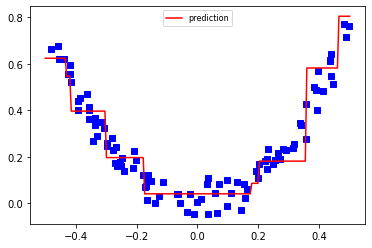

In [21]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)
plt.plot(X, y, 'bs')
plot_prediction([gbrt], [-0.5, 0.5], 'r-', 'prediction')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120)

In [24]:
errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)
print('Normal Gradient Boost Regressor error:', mean_squared_error(y_test, gbrt.predict(X_test)))
print('Best Gradient Boost Regressor error:', mean_squared_error(y_test, gbrt_best.predict(X_test)))

Normal Gradient Boost Regressor error: 0.0024887982832709882
Best Gradient Boost Regressor error: 0.002426746794968738


Text(0.5, 1.0, 'Best model (99 trees)')

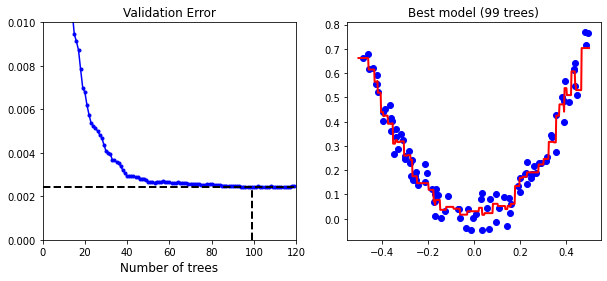

In [25]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(errors, 'b.-')
plt.plot([best_n_estimators, best_n_estimators], [0, errors[best_n_estimators]], 'k--', linewidth=2)
plt.plot([0, 120], [errors[best_n_estimators]] * 2, 'k--', linewidth=2)
plt.xlabel('Number of trees', fontsize=12)
plt.axis([0, 120, 0, 0.01])
plt.title('Validation Error')
plt.subplot(122)
plt.plot(X, y, 'bo')
X_new = np.linspace(-0.5, 0.5, 500)
plt.plot(X_new, gbrt_best.predict(X_new.reshape(-1, 1)), 'r-', linewidth=2)
plt.title(f'Best model ({best_n_estimators} trees)')

In [26]:
xgb_reg = XGBRegressor(learning_rate=0.1, early_stopping_rounds=3, n_jobs=-1)
xgb_reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
mean_squared_error(y_test, xgb_reg.predict(X_test))

[03:27:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.0025592463604717976